**Nama: Riski Abdi Rahmawan**

**Kelas: TI-3E**

**Absen: 25**

**Jobsheet**

# Praktikum 1

**Instalasi dan Import Library**

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
import re
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [10]:
IMG_DIR = '/content/drive/MyDrive/Machine Learning/assets/images-ocr/images/'

**Preprocessing images dengan OpenCV**

**Metode yang berbeda dapat berguna untuk jenis gambar yang berbeda**

In [11]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

**Mari kita bekerja dengan sebuah contoh Image untuk melihat segalanya dengan lebih baik. Seperti inilah gambar asli sebelum di proses**

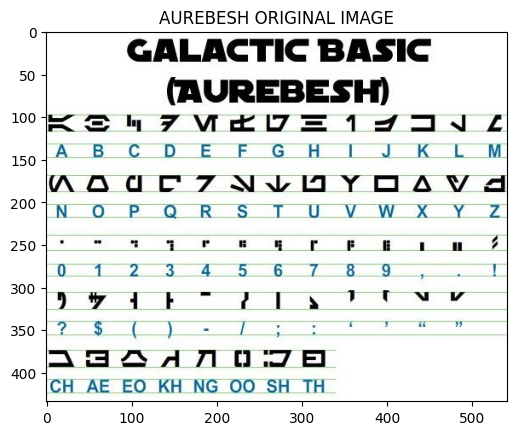

In [12]:
# Plot original image

image = cv2.imread(IMG_DIR + 'aurebesh.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('AUREBESH ORIGINAL IMAGE')
plt.show()

**Selanjutnya lakukan pre-processing, dan setelah dilakukan preprocessing dengan kode berikut, makan akan didapatkan hasil imgae baru**

In [13]:
# Preprocess image

gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray,
          'thresh': thresh,
          'opening': opening,
          'canny': canny}

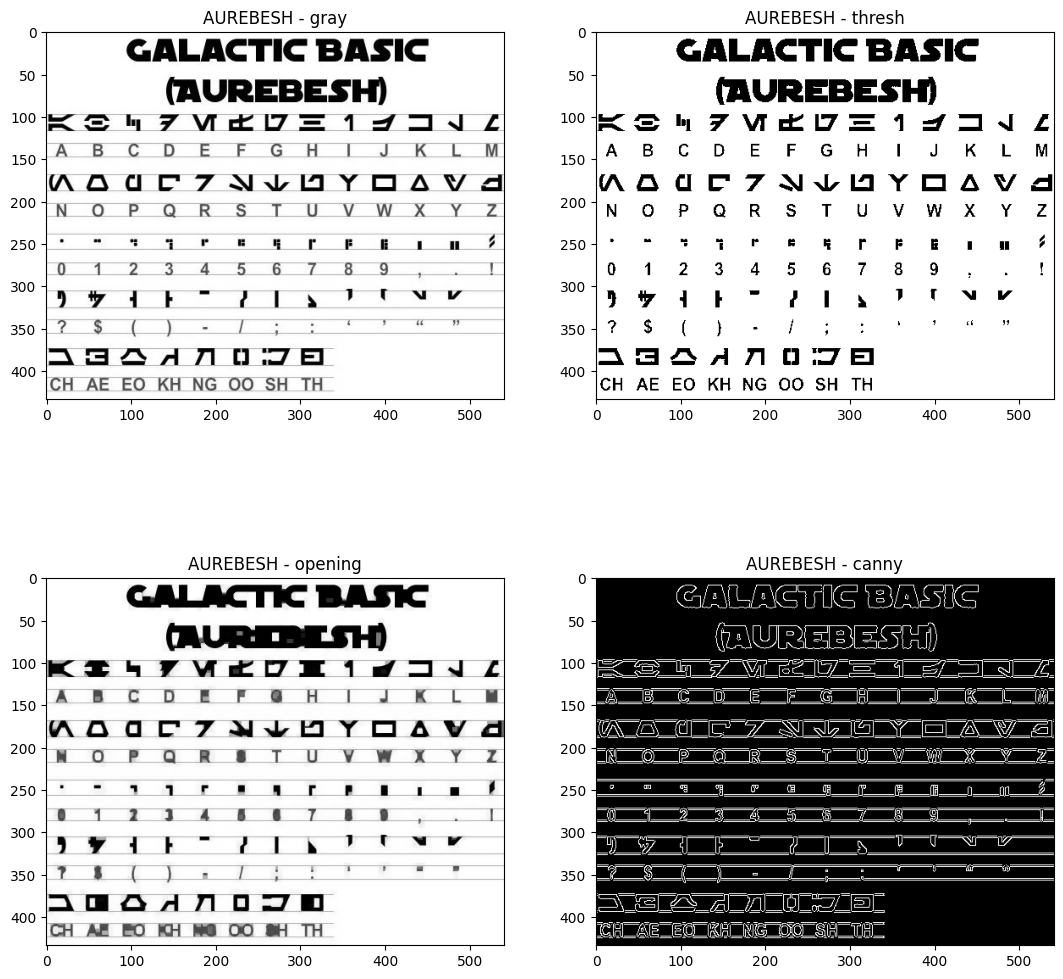

In [14]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('AUREBESH - ' + keys[i])
    plt.imshow(images[keys[i]], cmap='gray')

**Langkah selanjutnya akan kita lakukan ekstraksi data dari images tersebut dengan teknik OCR melalui code berikut**

In [15]:
# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------------------------
GALACTIC BASIC
(AUREBESH)

RE TFVMVEVEStZIoNe
AB CD EF Ga KL
AOderT7NVYoYoOoOAVA
N_ Oo. 2 _ HG: Re SS Ty wee Ve
Ss eg ei
ed
i a a Sy ee ee ee
st
ASaSAnNADIE
CH AE EO KH NG OO SH TH


-----------------------------------------
TESSERACT OUTPUT --> CANNY EDGE IMAGE
-------

# Praktikum 2

**Bounding Box - Level Karakter**

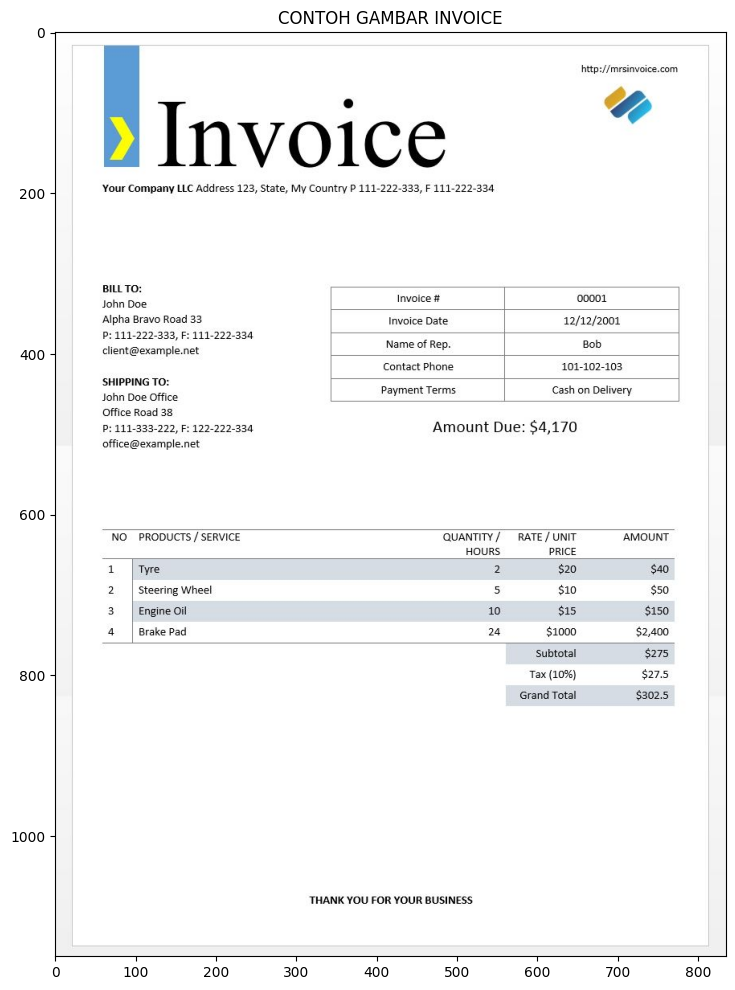

In [16]:
# Plot gambar original

# Membaca gambar dari direktori
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Memisahkan saluran warna (blue, green, red) karena matplotlib menggunakan skema warna RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dalam ukuran tertentu
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH GAMBAR INVOICE')
plt.show()

**kode program berikut akan memberikan hasil bounding box pada image invoice**

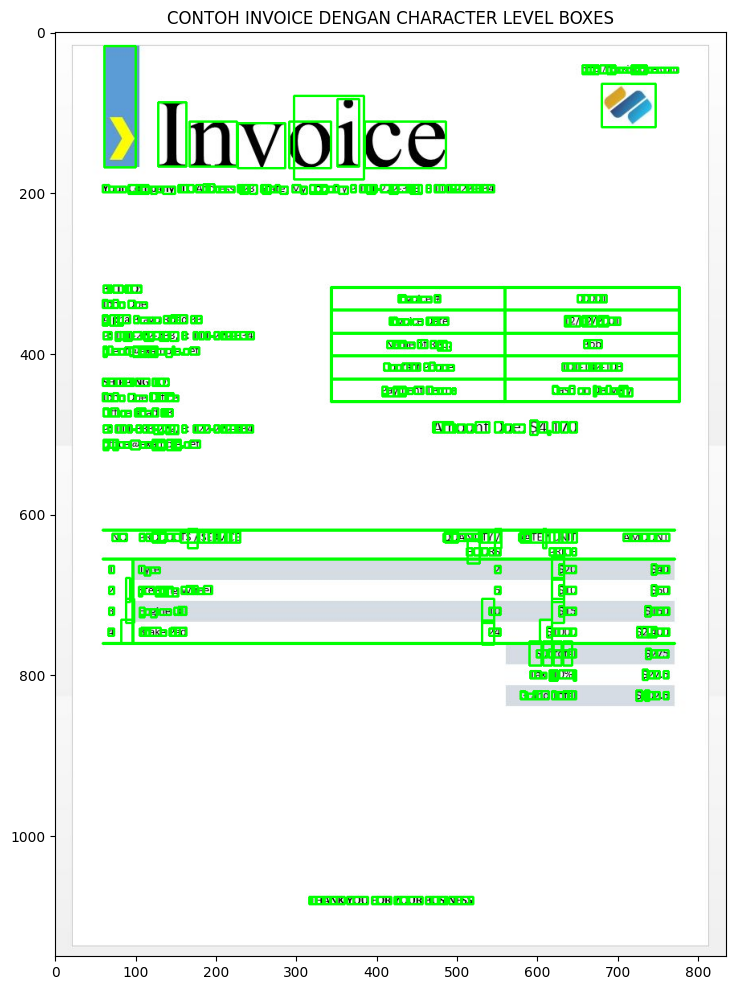

In [17]:
# Membaca gambar dari direktori
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Mendapatkan dimensi tinggi (h), lebar (w), dan channel warna (c) dari gambar
h, w, c = image.shape

# Menggunakan pytesseract.image_to_boxes() untuk mendapatkan informasi kotak karakter
boxes = pytesseract.image_to_boxes(image)

# Iterasi melalui setiap baris hasil dan membuat kotak pada gambar menggunakan OpenCV
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dengan kotak karakter
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH INVOICE DENGAN CHARACTER LEVEL BOXES')
plt.show()

**Bounding Box - Level Kata**

In [18]:
# Membaca gambar contoh invoice
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Menggunakan pytesseract.image_to_data() untuk mendapatkan data teks dari gambar
d = pytesseract.image_to_data(image, output_type=Output.DICT)

# Menampilkan kunci-kunci data yang diperoleh dari hasil OCR
print('DATA KEYS: \n', d.keys())

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


**Selanjutnya pada code berikut digunakan untuk memfilter dan hanya menampilkan kotak-kotak kata yang memiliki tingkat kepercayaan (confidence) lebih dari 60%. Hasilnya, gambar contoh invoice akan ditampilkan dengan kotak-kotak yang menandai lokasi setiap kata dengan tingkat kepercayaan yang memenuhi syarat.**

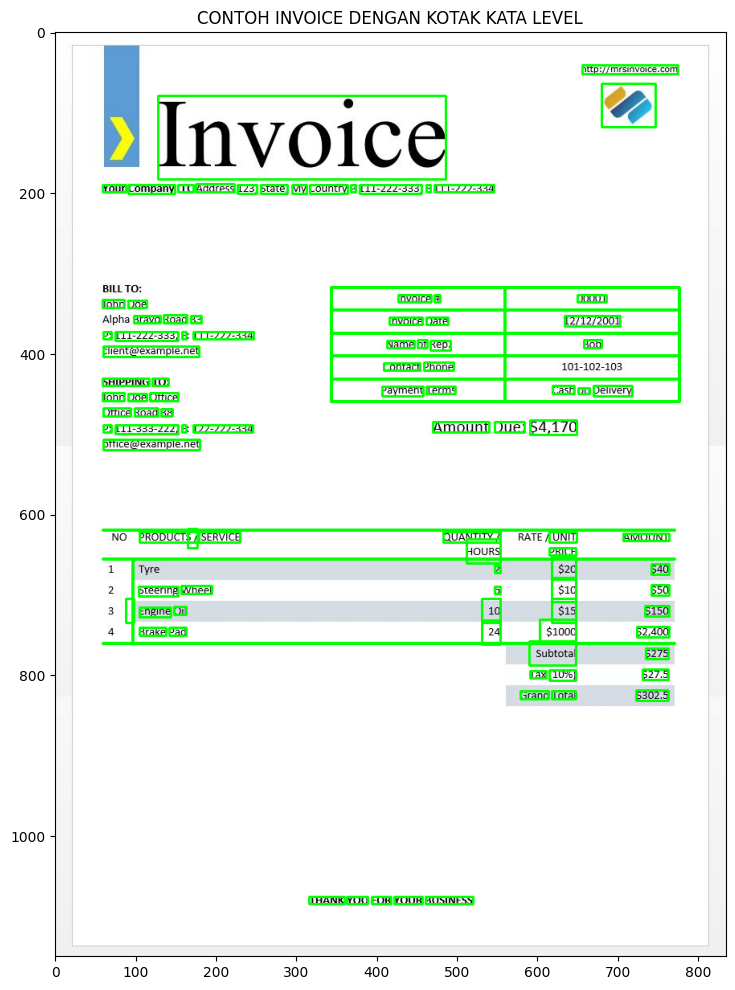

In [19]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    # Kondisi untuk hanya memilih kotak dengan kepercayaan > 60%
    if int(d['conf'][i]) > 60:
        # Mendapatkan koordinat dan ukuran kotak kata
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        # Membuat kotak pada gambar untuk kata dengan kepercayaan > 60%
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dengan kotak kata berdasarkan kepercayaan > 60%
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH INVOICE DENGAN KOTAK KATA LEVEL')
plt.show()

**Text template matching - Pola Regex**

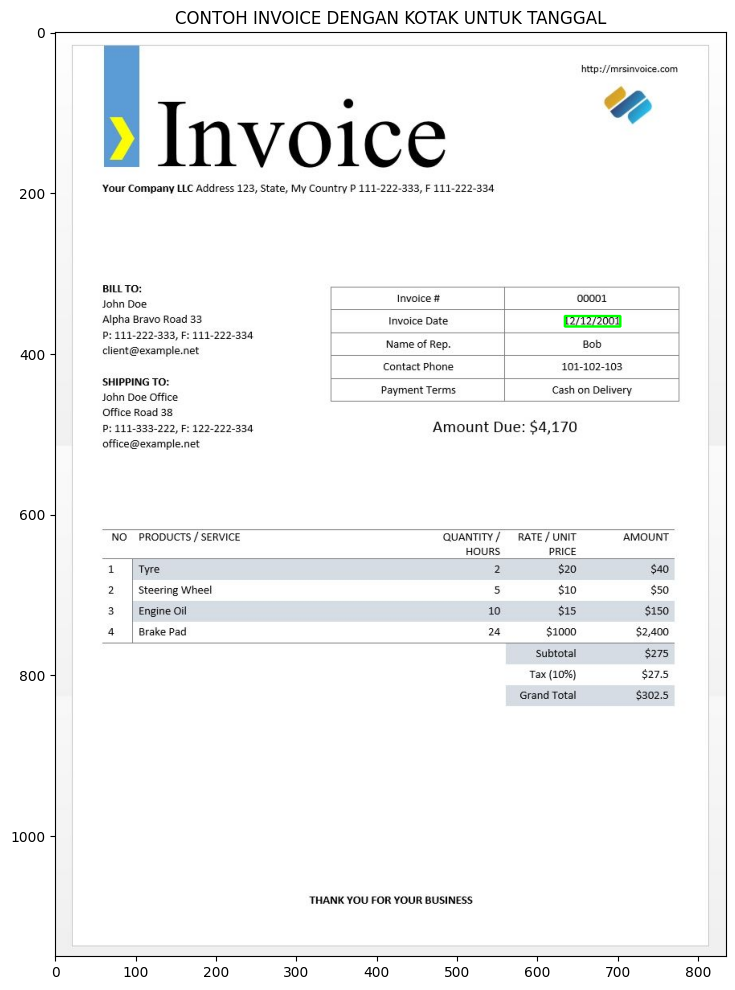

In [20]:
image = cv2.imread(IMG_DIR + 'invoice-sample.jpg')

# Pola tanggal dalam format dd/mm/yyyy
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    # Memeriksa apakah kotak memiliki tingkat kepercayaan lebih dari 60%
    if int(d['conf'][i]) > 60:
        # Memeriksa apakah teks di dalam kotak sesuai dengan pola tanggal
        if re.match(date_pattern, d['text'][i]):
            # Mendapatkan koordinat dan ukuran kotak kata
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            # Membuat kotak pada gambar untuk tanggal yang sesuai dengan pola
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar dengan kotak-kotak yang menandai lokasi tanggal
plt.figure(figsize=(16, 12))
plt.imshow(rgb_img)
plt.title('CONTOH INVOICE DENGAN KOTAK UNTUK TANGGAL')
plt.show()

**Deteksi berbagai bahasa - OCR**

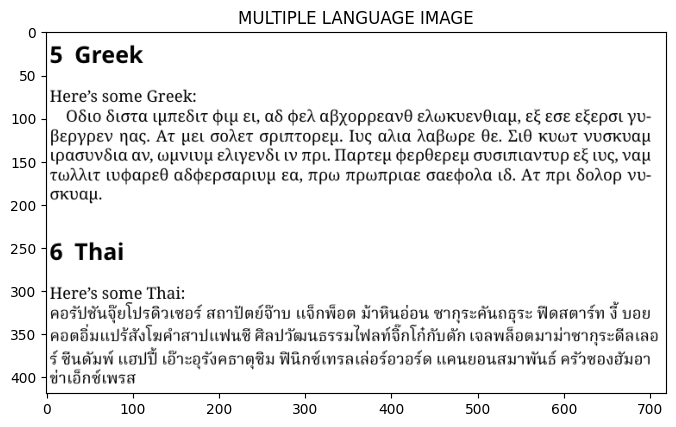

In [21]:
# Membaca gambar asli
image = cv2.imread(IMG_DIR + 'greek-thai.png')

# Memisahkan channel warna untuk mengonversi dari BGR ke RGB
b, g, r = cv2.split(image)
rgb_img = cv2.merge([r, g, b])

# Menampilkan gambar asli
plt.figure(figsize=(8, 16))
plt.imshow(rgb_img, cmap='gray')
plt.title('MULTIPLE LANGUAGE IMAGE')
plt.show()

In [22]:
# Output dengan hanya bahasa Inggris yang ditentukan

# Konfigurasi khusus dengan hanya bahasa Inggris yang diatur
custom_config = r'-l eng --oem 3 --psm 6'

# Menggunakan pytesseract.image_to_string() untuk mendapatkan teks dari gambar dengan konfigurasi khusus
print(pytesseract.image_to_string(image, config=custom_config))

5 Greek
Here’s some Greek:

OSto Stota tuMedit Huy et, aS ea aByoppeave edAwkvevOuay, e§ ece efepot yu-
Bepypev nas. AT Wel GoAET apiTtopen. Tug aAta AaBwpe Ve. LO KUWT VUoKLaL
(paovvéia av, WUVLUU eAtyevil tv mpL TMaptep bepSepey GvaTLAaVTUp e€€ LUG, Va
TWAALT LUdaped ASdepoapluy Ea, TOW TpwTplae Gaedoda 16. AT mpt SoAop vv-
oxvau.

6 Thai

Here’s some Thai: .
aosUsugulushawos amiaddw usntioa sinfudou winszduagss Haaonsn 3 vos
Aonduusaladrawunud AavTausssulwavianlAdudn wandoamnsiwinsedataa
$ Guduvi woud rvaseasiadu Windinsadosor0sa uausouanrwus aswouduer
didadinsa



TUGAS

**Import Library**

In [23]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [24]:
import re
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

**Persiapan Gambar**

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


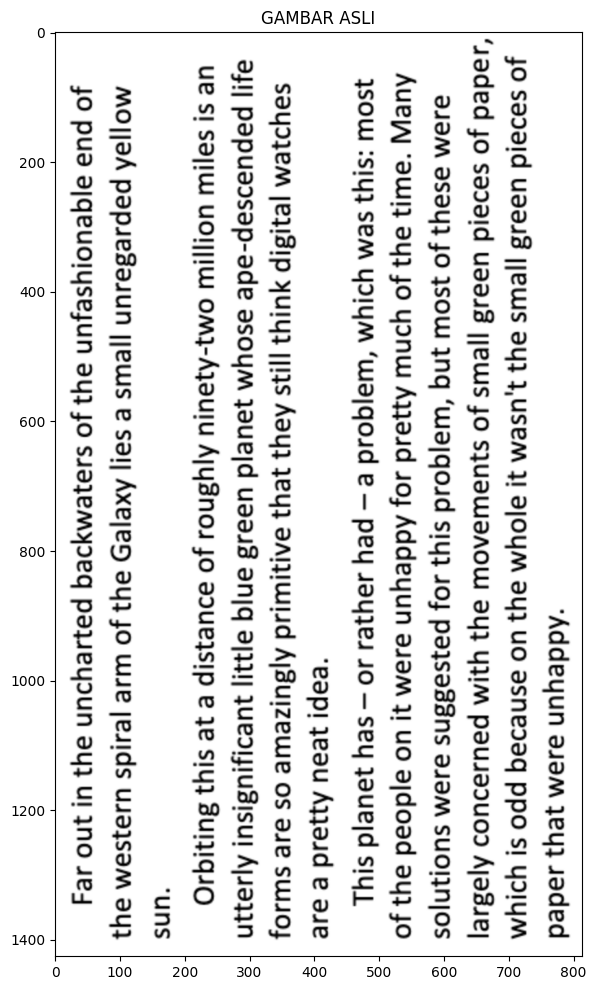

In [26]:
# Membaca gambar dari direktori
image = cv2.imread('/content/drive/MyDrive/Machine Learning/assets/images-ocr/images/hitchhikers-rotated.png')

# Tampilkan gambar asli
plt.figure(figsize=(16, 12))
plt.imshow(image)
plt.title('GAMBAR ASLI')
plt.show()

**Deteksi Orientasi dan Skrip**

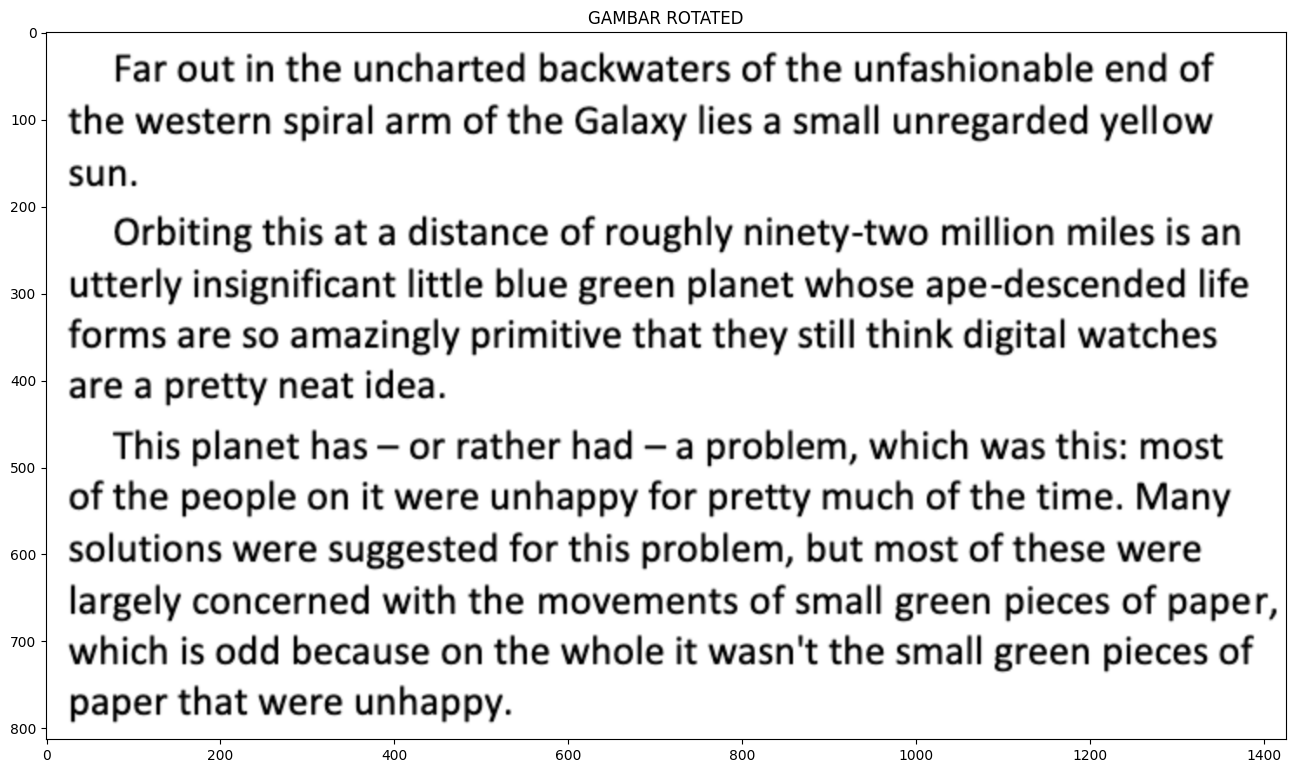

Sudut Rotasi Teks: 90.0 derajat
Jenis Skrip: 
Far out in the uncharted backwaters of the unfashionable end of
the western spiral arm of the Galaxy lies a small unregarded yellow
sun.

Orbiting this at a distance of roughly ninety-two million miles is an
utterly insignificant little blue green planet whose ape-descended life
forms are so amazingly primitive that they still think digital watches
are a pretty neat idea.

This planet has — or rather had — a problem, which was this: most
of the people on it were unhappy for pretty much of the time. Many
solutions were suggested for this problem, but most of these were
largely concerned with the movements of small green pieces of paper,
which is odd because on the whole it wasn't the small green pieces of
paper that were unhappy.



In [27]:
def get_text_orientation_and_script(image):
    # Mendapatkan sudut rotasi
    osd = pytesseract.image_to_osd(image)
    rotation_angle = float(osd.split('\n')[2].split(':')[1])

    # Gunakan Tesseract untuk mendeteksi teks
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    text = pytesseract.image_to_string(rotated_image)

    return text, rotation_angle, rotated_image


# Dapatkan teks, orientasi teks, jenis skrip, dan gambar yang telah diputar
text, rotation_angle, rotated_image = get_text_orientation_and_script(image)

# Tampilkan gambar yang telah diputar, hasil orientasi dan jenis skrip
plt.figure(figsize=(16, 12))
plt.imshow(rotated_image)
plt.title('GAMBAR ROTATED')
plt.show()
print(f"Sudut Rotasi Teks: {rotation_angle} derajat")
print(f"Jenis Skrip: \n{text}")